In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

   price  maint doors persons lug_capacity safety output
0  vhigh  vhigh     2       2        small    low  unacc
1  vhigh  vhigh     2       2        small    med  unacc
2  vhigh  vhigh     2       2        small   high  unacc
3  vhigh  vhigh     2       2          med    low  unacc
4  vhigh  vhigh     2       2          med    med  unacc


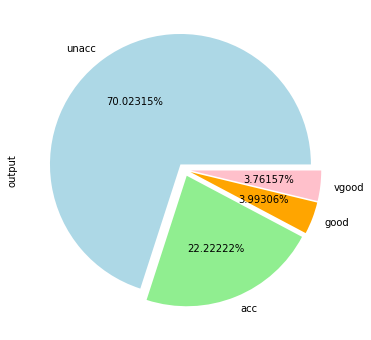

Case 0: SGD
------------------------------------------------------------
Epoch:0/1000 Error_train:1.5267947 Error_test:1.5249777
Epoch:100/1000 Error_train:0.47600543 Error_test:0.4998373
Epoch:200/1000 Error_train:0.28711665 Error_test:0.32321712
Epoch:300/1000 Error_train:0.19960327 Error_test:0.24418326
Epoch:400/1000 Error_train:0.14766243 Error_test:0.20131978
Epoch:500/1000 Error_train:0.11542271 Error_test:0.17594425
Epoch:600/1000 Error_train:0.09215048 Error_test:0.16027196
Epoch:700/1000 Error_train:0.07369423 Error_test:0.14494409
Epoch:800/1000 Error_train:0.058792897 Error_test:0.13443889
Epoch:900/1000 Error_train:0.046772286 Error_test:0.12442093


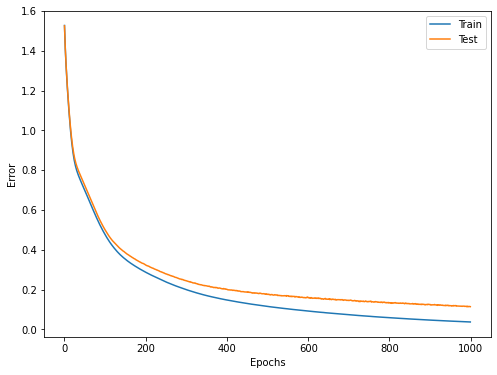

Accuracy Train: 99.76851851851852% Accuracy Test: 94.44444444444444%
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 21)                462       
_________________________________________________________________
dense_17 (Dense)             (None, 25)                550       
_________________________________________________________________
dense_18 (Dense)             (None, 25)                650       
_________________________________________________________________
dense_19 (Dense)             (None, 4)                 104       
Total params: 1,766
Trainable params: 1,766
Non-trainable params: 0
_________________________________________________________________
None
Case 1: adagrad
------------------------------------------------------------
Epoch:0/1000 Error_train:1.3730178 Error_test:1.380598
Epoch:100/1000 Error_train:0.30351692 Error_

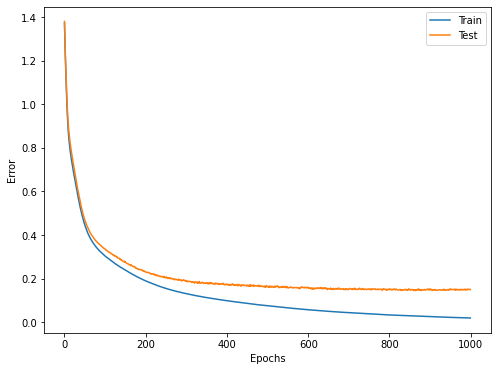

Accuracy Train: 99.88425925925925% Accuracy Test: 95.13888888888889%
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 21)                462       
_________________________________________________________________
dense_21 (Dense)             (None, 25)                550       
_________________________________________________________________
dense_22 (Dense)             (None, 25)                650       
_________________________________________________________________
dense_23 (Dense)             (None, 4)                 104       
Total params: 1,766
Trainable params: 1,766
Non-trainable params: 0
_________________________________________________________________
None
Case 2: SGD + dropout
------------------------------
Epoch:0/1000 Error_train:1.1979972 Error_test:1.2134398
Epoch:100/1000 Error_train:0.5620234 Error_test:0.59148055
Epoch:20

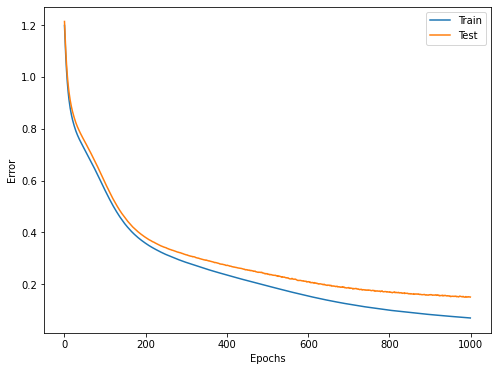

Accuracy Train: 98.95833333333334% Accuracy Test: 93.63425925925925%
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 21)                462       
_________________________________________________________________
dense_25 (Dense)             (None, 25)                550       
_________________________________________________________________
dense_26 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 4)                 104       
Total params: 1,766
Trainable params: 1,766
Non-trainable params: 0
_________________________________________________________________
None
Case 3: adagrad + dropout
------------------

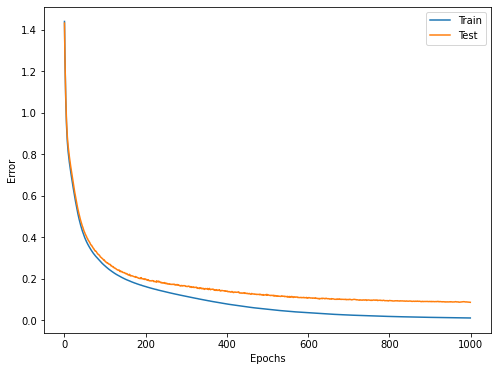

Accuracy Train: 100.0% Accuracy Test: 96.52777777777779%
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 21)                462       
_________________________________________________________________
dense_29 (Dense)             (None, 25)                550       
_________________________________________________________________
dense_30 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_3 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 4)                 104       
Total params: 1,766
Trainable params: 1,766
Non-trainable params: 0
_________________________________________________________________
None


In [4]:
class fc_model:
  def __init__(self, optimizer, eta, n_in, n_mid, n_out, dropout_ratio=0.):
    if dropout_ratio == 0.: 
      self.model = Sequential([
          Dense(n_in, activation='relu'),
          Dense(n_mid, activation='relu'),
          Dense(n_mid, activation='relu'),
          Dense(n_out, activation='softmax')
      ])
    else:
      self.model = Sequential([
          Dense(n_in, activation='relu'),
          Dense(n_mid, activation='relu'),
          # Dropout(dropout_ratio),
          Dense(n_mid, activation='relu'),
          Dropout(dropout_ratio),
          Dense(n_out, activation='softmax')
      ]) 

    self.loss_fn = tf.keras.losses.CategoricalCrossentropy()

    if optimizer == "SGD":
      self.optimizer = tf.keras.optimizers.SGD(learning_rate=eta)
    elif optimizer == "adagrad":
      self.optimizer = tf.keras.optimizers.Adagrad(learning_rate=eta)

    
  def train_test(self, X_train, y_train, X_test, y_test, n_train, n_test, batch_size, epoch, interval):
    # -- 오차 기록용 --
    train_acc_metrics = tf.keras.metrics.CategoricalCrossentropy()
    test_acc_metrics = tf.keras.metrics.CategoricalCrossentropy()

    train_error_x = []
    train_error_y = []
    test_error_x = []
    test_error_y = []

    n_batch = n_train // batch_size # 1에포크 당 배치 수
    for i in range(epoch):
        # --오차 계측 --
        pred_train = self.model(X_train)
        train_acc_metrics(y_train, pred_train)
        error_train = train_acc_metrics.result().numpy()
        pred_test = self.model(X_test)
        test_acc_metrics(y_test, pred_test)
        error_test = test_acc_metrics.result().numpy()

        train_acc_metrics.reset_states()
        test_acc_metrics.reset_states()

        # -- 오차 기록 --
        train_error_x.append(i)
        train_error_y.append(error_train)
        test_error_x.append(i)
        test_error_y.append(error_test)

        # -- 경과 표시 --
        if i%interval == 0:
            print("Epoch:" + str(i) + "/" + str(epoch),
                  "Error_train:" + str(error_train),
                  "Error_test:" + str(error_test))
        
        # -- 학습 --
        index_random = np.arange(n_train)
        np.random.shuffle(index_random) # 인덱스 임의 섞기
        for j in range(n_batch):

            # 미니배치 샘플 추출
            mb_index = index_random[j*batch_size : (j+1)*batch_size]
            x = X_train[mb_index, :]
            t = y_train[mb_index, :]

            # 순전파와 역전파
            with tf.GradientTape() as tape:
                predictions = self.model(x)
                loss = self.loss_fn(t, predictions)
            
            gradients = tape.gradient(loss, self.model.trainable_weights)

            # 가중치와 편향 수정
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_weights))

    # -- 기록된 오차를 그래프로 표시 -- 
    plt.plot(train_error_x, train_error_y, label="Train")
    plt.plot(test_error_x, test_error_y, label="Test")
    plt.legend()

    plt.xlabel("Epochs")
    plt.ylabel("Error")

    plt.show()

    # -- 정답률 측정 -- 
    predictions_train = self.model(X_train)
    count_train = np.sum(np.argmax(predictions_train, axis=1) == np.argmax(y_train, axis=1))

    predictions_test = self.model(X_test)
    count_test = np.sum(np.argmax(predictions_test, axis=1) == np.argmax(y_test, axis=1))

    print("Accuracy Train:", str(count_train/n_train*100) + "%",
          "Accuracy Test:", str(count_test/n_test*100) + "%")
    print(self.model.summary())
    
def end_to_end_training():
  # -- car_evaluation 데이터 읽어 들이기 --  
  cols = ['price', 'maint', 'doors', 'persons', 'lug_capacity', 'safety','output']
  cars = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/car_evaluation.csv", names=cols, header=None)
  n_data = len(cars)  # 샘플 수

  print(cars.head())

  plot_size = plt.rcParams["figure.figsize"]
  plot_size [0] = 8
  plot_size [1] = 6
  plt.rcParams["figure.figsize"] = plot_size

  cars.output.value_counts().plot(kind='pie', autopct='%0.05f%%', colors=['lightblue', 'lightgreen', 'orange', 'pink'], explode=(0.05, 0.05, 0.05,0.05))

  plt.show()

  # -- 정답을 원-핫 인코딩으로 변경 --
  price = pd.get_dummies(cars.price, prefix='price')
  maint = pd.get_dummies(cars.maint, prefix='maint')

  doors = pd.get_dummies(cars.doors, prefix='doors')
  persons = pd.get_dummies(cars.persons, prefix='persons')

  lug_capacity = pd.get_dummies(cars.lug_capacity, prefix='lug_capacity')
  safety = pd.get_dummies(cars.safety, prefix='safety')

  labels = pd.get_dummies(cars.output, prefix='condition')

  # -- 훈련 데이터와 테스트 데이터 --
  index = np.arange(n_data)
  index_train = index[index%2 == 0]
  index_test = index[index%2 != 0]

  input_data = pd.concat([price, maint, doors, persons, lug_capacity, safety] , axis=1)
  correct_data = labels.values

  input_train = input_data.iloc[index_train, :]  # 훈련데이터 입력
  input_train = input_train.to_numpy()
  correct_train = correct_data[index_train, :]  # 훈련데이터 정답
  input_test = input_data.iloc[index_test, :]  # 테스트데이터 입력
  input_test = input_test.to_numpy()
  correct_test = correct_data[index_test, :]  # 테스트데이터 정답

  n_train = input_train.shape[0]  # 훈련데이터 샘플 수
  n_test = input_test.shape[0]  # 테스트데이터 샘플 수

  # -- 각 설정 값 --
  n_in = input_train.shape[1]  # 입력층 뉴런 수
  n_mid = 25  # 은닉층 뉴런 수
  n_out = correct_train.shape[1]  # 출력층 뉴런 수

  wb_width = 0.1  # 가중치와 편향 설정을 위한 정규분포 표준편차
  eta = 0.01  # 학습률
  epoch = 1000
  batch_size = 128
  interval = 100  # 경과 표시 간격

  optimizers = ["SGD", "adagrad"]
  dropout_ratio = 0.5

  for i, opt in enumerate(optimizers):
    print("=" * 60)
    print(f"Case {i}: {opt}")
    print("-" * 60)
    simple_model = fc_model(opt, eta, n_in, n_mid, n_out)
    simple_model.train_test(input_train, correct_train, input_test, correct_test, n_train, n_test, batch_size, epoch, interval)
  for i, opt in enumerate(optimizers):
    print("=" * 60)
    print(f"Case {i + 2}: {opt} + dropout")
    print("-" * 30)
    dropout_model = fc_model(opt, eta, n_in, n_mid, n_out, dropout_ratio)
    dropout_model.train_test(input_train, correct_train, input_test, correct_test, n_train, n_test, batch_size, epoch, interval)
    
end_to_end_training()